--- 1. Loading Data from ITSM_data.csv ---


C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_16260\3144715225.py:22: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ITSM_data.csv')


CSV file loaded successfully.
Initial Data Head:
     CI_Name          CI_Cat              CI_Subcat        WBS Incident_ID  \
0  SUB000508  subapplication  Web Based Application  WBS000162   IM0000004   
1  WBA000124     application  Web Based Application  WBS000088   IM0000005   
2  DTA000024     application    Desktop Application  WBS000092   IM0000006   
3  WBA000124     application  Web Based Application  WBS000088   IM0000011   
4  WBA000124     application  Web Based Application  WBS000088   IM0000012   

   Status Impact Urgency  Priority  number_cnt  ...      Reopen_Time  \
0  Closed      4       4       4.0    0.601292  ...              NaN   
1  Closed      3       3       3.0    0.415050  ...  2/12/2023 12:31   
2  Closed     NS       3       NaN    0.517551  ...              NaN   
3  Closed      4       4       4.0    0.642927  ...              NaN   
4  Closed      4       4       4.0    0.345258  ...              NaN   

      Resolved_Time        Close_Time  Handle_Tim

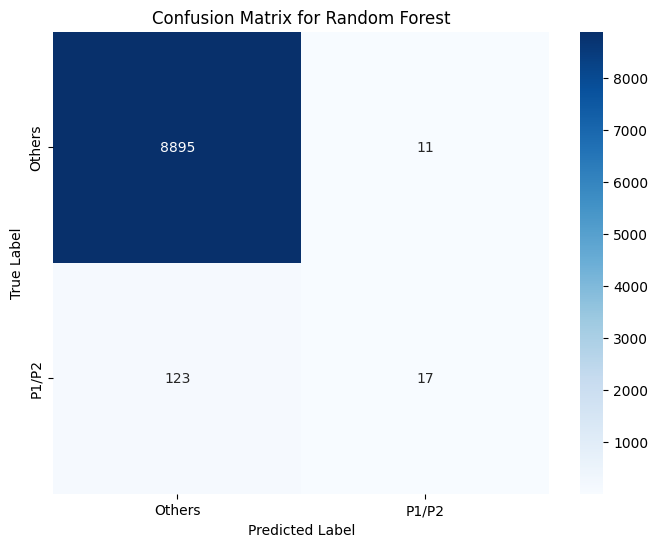


--- End of Script ---


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


print("--- 1. Loading Data from ITSM_data.csv ---")

try:
    df = pd.read_csv('ITSM_data.csv')
    print("CSV file loaded successfully.")
    print("Initial Data Head:")
    print(df.head())
    print("\nInitial Data Info:")
    df.info()
except FileNotFoundError:
    print("Error: ITSM_data.csv not found. Please ensure the file is in the correct directory.")


print("\n--- Data Cleaning and Feature Engineering ---")

df['Priority'] = pd.to_numeric(df['Priority'], errors='coerce')

df.dropna(subset=['Priority'], inplace=True)

df['Priority'] = df['Priority'].astype(int)

print("\nPriority Distribution in Raw Data:")
print(df['Priority'].value_counts().sort_index())

df['issue_description'] = df['CI_Name'].fillna('') + ' ' + \
                          df['CI_Cat'].fillna('') + ' ' + \
                          df['CI_Subcat'].fillna('') + ' ' + \
                          df['Category'].fillna('')

df['issue_description'] = df['issue_description'].str.strip().str.replace(r'\s+', ' ', regex=True)

df['CI_Cat'] = df['CI_Cat'].astype(str)

print("\nSample Data Head after Feature Engineering:")
print(df[['issue_description', 'CI_Cat', 'Priority']].head())



print("\n--- 2. Data Preprocessing ---")

df['target_priority'] = df['Priority'].apply(lambda x: 1 if x in [1, 2] else 0)

print("\nTarget Variable Distribution ('Priority 1/2' vs. 'Others'):")
print(df['target_priority'].value_counts())

X = df[['issue_description', 'CI_Cat']]
y = df['target_priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

preprocessor = ColumnTransformer(
    transformers=[
        ('text_vectorizer', TfidfVectorizer(stop_words='english', max_features=1000), 'issue_description'),
        ('categorical_encoder', OneHotEncoder(handle_unknown='ignore'), ['CI_Cat'])
    ],
)


print("\n--- 3. Model Training and Evaluation ---")

models = {
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))]),
    'Decision Tree': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', DecisionTreeClassifier(random_state=42))]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', RandomForestClassifier(random_state=42))]),
    'Support Vector Machine': Pipeline(steps=[('preprocessor', preprocessor),
                                              ('classifier', SVC())]),
    'Gradient Boosting': Pipeline(steps=[('preprocessor', preprocessor),
                                         ('classifier', GradientBoostingClassifier(random_state=42))]),
    'K-Nearest Neighbors': Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', KNeighborsClassifier())]),
        }

results = {}

best_model_name = None
best_f1_score = -1

for name, model in models.items():
    print(f"\nTraining and Evaluating: {name}")
    try:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=['Others', 'P1/P2'], zero_division=0)


        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'classification_report': report
        }

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print("  Confusion Matrix:\n", cm)
        print("  Classification Report:\n", report)

        if f1 > best_f1_score:
            best_f1_score = f1
            best_model_name = name

    except Exception as e:
        print(f"  Error training/evaluating {name}: {e}")
        results[name] = {'error': str(e)}

print("\n--- Evaluation Summary ---")
for name, metrics in results.items():
    if 'error' in metrics:
        print(f"{name}: Error - {metrics['error']}")
    else:
        print(f"{name}: Accuracy={metrics['accuracy']:.4f}, F1-Score={metrics['f1_score']:.4f}")

print(f"\nBest performing model based on F1-Score: {best_model_name} (F1-Score: {best_f1_score:.4f})")


print("\n--- 4. Prediction with the Best Model ---")

if best_model_name:
    best_model = models[best_model_name]

    new_tickets_data = pd.DataFrame({
        'issue_description': [
            'critical system down production outage',
            'user login issue password reset needed',
            'network slowness building A multiple users',
            'new feature request reporting module',
            'typo user guide section 3.2',
            'high severity security alert server X investigate'
        ],
        'CI_Cat': [
            'application',
            'subapplication',
            'application',
            'application',
            'subapplication',
            'application'
        ]
    })

    print("\nNew Tickets for Prediction:")
    print(new_tickets_data)

    new_predictions = best_model.predict(new_tickets_data)
    new_prediction_proba = best_model.predict_proba(new_tickets_data)

    prediction_labels = np.array(['Others', 'P1/P2'])[new_predictions]

    print(f"\nPredictions using the {best_model_name} model:")
    for i, (desc, cat, pred, proba) in enumerate(zip(new_tickets_data['issue_description'], new_tickets_data['CI_Cat'], prediction_labels, new_prediction_proba)):
        print(f"Ticket {i+1}: Description='{desc}', Category='{cat}'")
        print(f"  Predicted Priority: {pred}")
        print(f"  Probability (Others): {proba[0]:.4f}, Probability (P1/P2): {proba[1]:.4f}\n")

    print(f"\n--- Visualizing Confusion Matrix for {best_model_name} ---")
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[best_model_name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Others', 'P1/P2'], yticklabels=['Others', 'P1/P2'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.show()

else:
    print("No best model found due to errors in training all models.")

print("\n--- End of Script ---")
